In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
from statannotations.Annotator import Annotator

In [2]:
in_dir = '../../results/07_marchphages/01_mac_clustering'
out_dir = '../../results/07_marchphages/02_annotate'

os.makedirs(out_dir, exist_ok=True)

In [3]:
adata = sc.read_h5ad(f'{in_dir}/macrophages.h5ad')

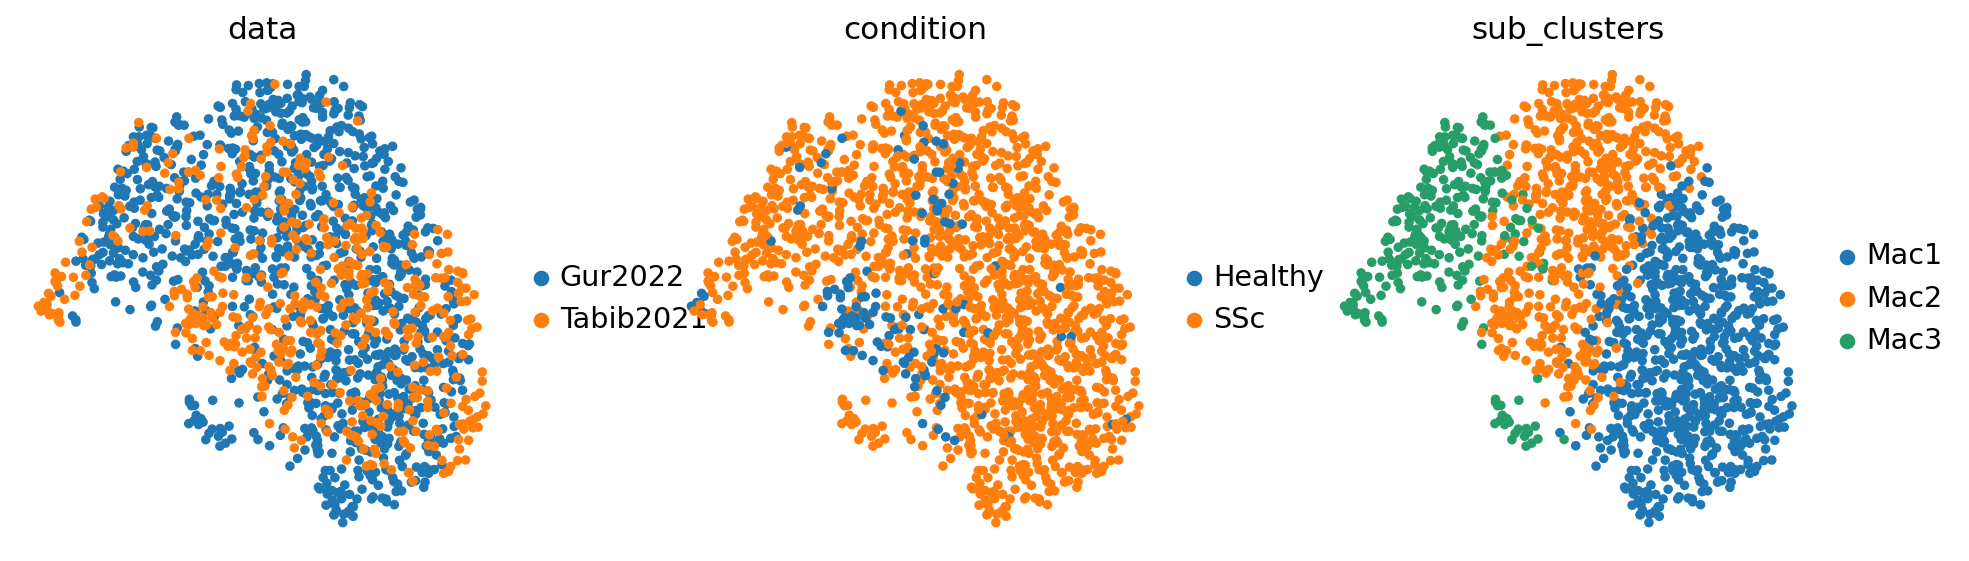

In [4]:
sc.set_figure_params(figsize=(4, 4))
sc.pl.umap(adata, color=['data', 'condition', 'sub_clusters'], frameon=False, ncols=3)

In [5]:
adata.obs['annotation'] = adata.obs['sub_clusters']
adata.obs['annotation'] = adata.obs['annotation'].str.replace(r'\bMac1\b', 'Pro-inflammatory', regex=True)
adata.obs['annotation'] = adata.obs['annotation'].str.replace(r'\bMac2\b', 'Phagocytic', regex=True)
adata.obs['annotation'] = adata.obs['annotation'].str.replace(r'\bMac3\b', 'Antigen-presenting', regex=True)

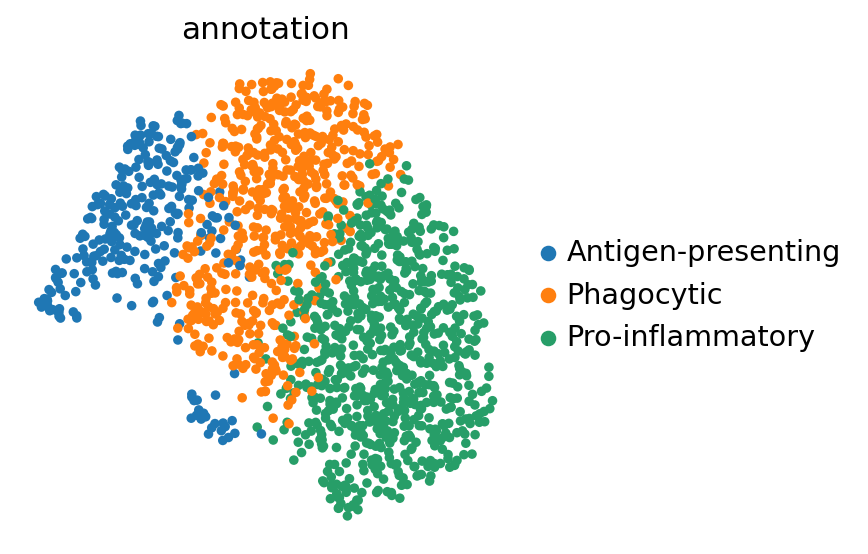

In [6]:
sc.set_figure_params(figsize=(4, 4))
sc.pl.umap(adata, color=['annotation'], frameon=False)

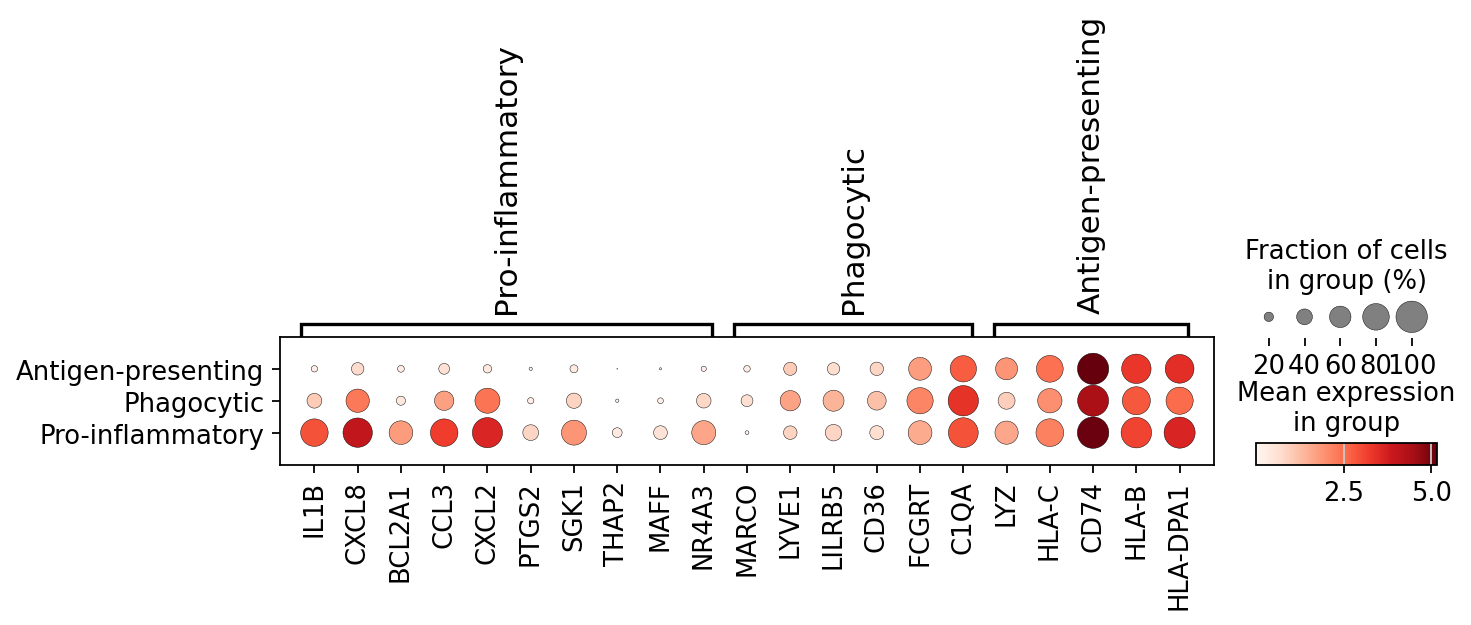

In [7]:
markers = {'Pro-inflammatory': ['IL1B', 'CXCL8', 'BCL2A1', 'CCL3', 'CXCL2', 'PTGS2', 'SGK1', 'THAP2', 'MAFF', 'NR4A3'],
           'Phagocytic': ['MARCO', 'LYVE1', 'LILRB5', 'CD36', 'FCGRT', 'C1QA'],
           'Antigen-presenting': ['LYZ', 'HLA-C', 'CD74', 'HLA-B', 'HLA-DPA1']}
sc.pl.dotplot(adata, markers, groupby='annotation')

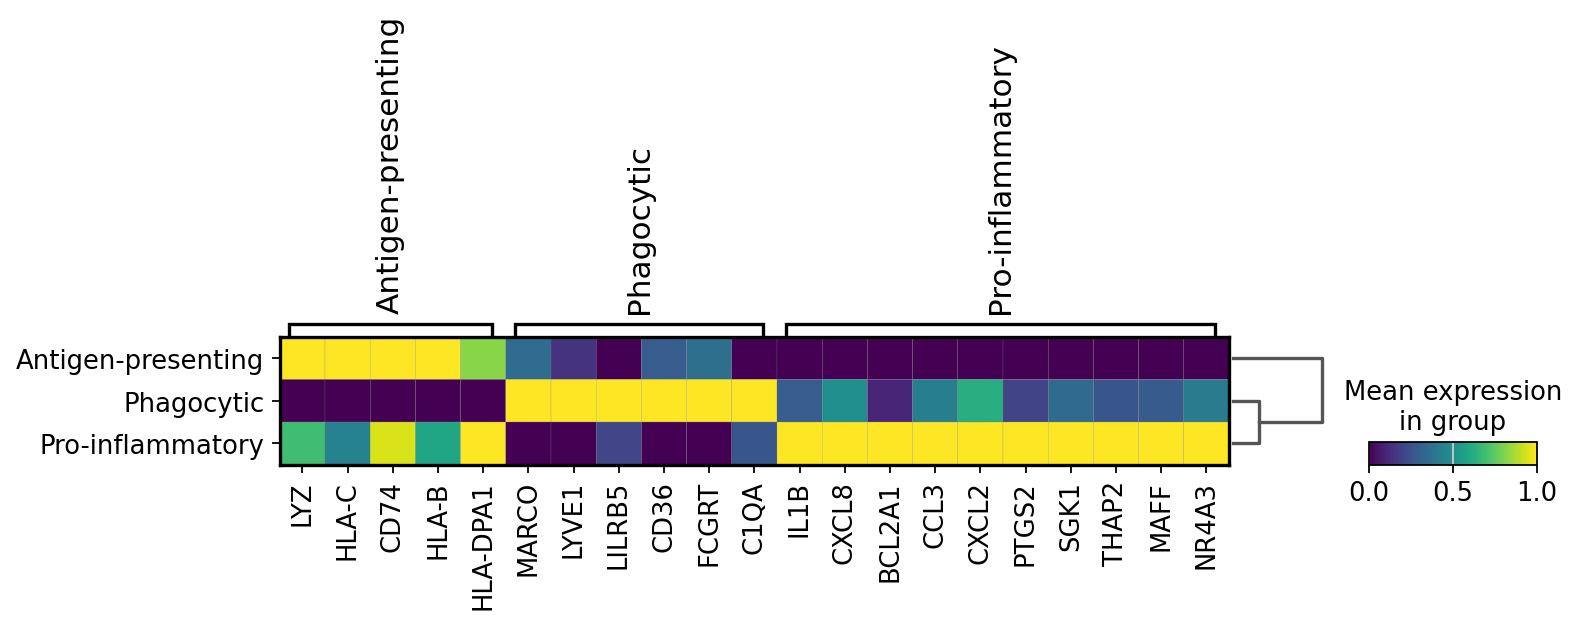

In [8]:
sc.pl.matrixplot(adata, markers, groupby='annotation', dendrogram=True, standard_scale='var')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Phagocytic_Healthy vs. Phagocytic_SSc: Mann-Whitney-Wilcoxon test two-sided, P_val:2.661e-02 U_stat=3.800e+01
Antigen-presenting_Healthy vs. Antigen-presenting_SSc: Mann-Whitney-Wilcoxon test two-sided, P_val:6.749e-01 U_stat=1.500e+01
Pro-inflammatory_Healthy vs. Pro-inflammatory_SSc: Mann-Whitney-Wilcoxon test two-sided, P_val:9.524e-03 U_stat=0.000e+00


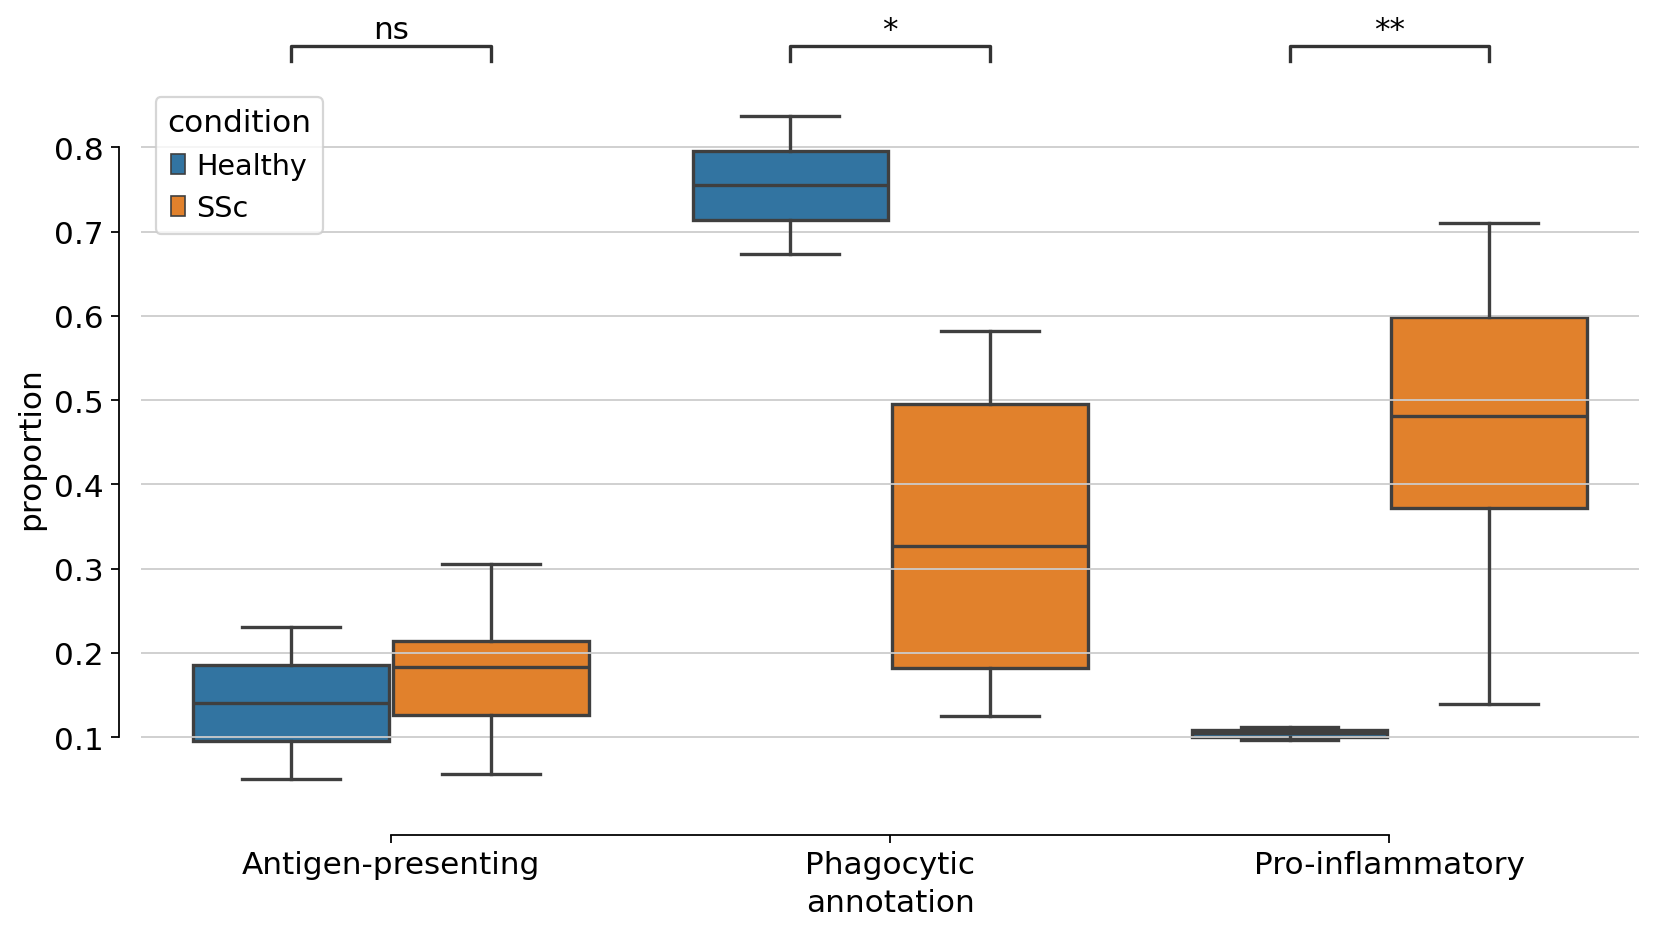

In [9]:
# we can compute the cell-type composition between control and SSc
df_prop = pd.crosstab(adata.obs['patient_id'],adata.obs['annotation'], normalize='index').reset_index()
df_obs = adata.obs[['patient_id', 'condition']].drop_duplicates()
df_prop = pd.melt(df_prop, id_vars=['patient_id'], value_name='proportion')
df = df_prop.merge(df_obs)

# visualize cell type proportion
sc.set_figure_params(figsize=(12, 6))
ax = sns.boxplot(data=df, 
                 x='annotation', y='proportion', 
                 hue="condition", 
                 showfliers = False)
sns.despine(offset=10, trim=True, ax=ax)

pairs=[(('Pro-inflammatory', "Healthy"), ('Pro-inflammatory', "SSc")),
      (('Phagocytic', "Healthy"), ('Phagocytic', "SSc")),
      (('Antigen-presenting', "Healthy"), ('Antigen-presenting', "SSc"))]

annotator = Annotator(ax, pairs, data=df, x='annotation', y='proportion', hue='condition')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

df.to_csv(f"{out_dir}/cell_proportion.csv")

In [10]:
# find marker genes
adata.uns['log1p']['base'] = None
sc.tl.rank_genes_groups(adata, 'annotation', method='wilcoxon')

In [11]:
# Extract marker genes, log fold changes, and p-values
results = []
for cluster in adata.uns['rank_genes_groups']['names'].dtype.names:
    cluster_marker_genes = adata.uns['rank_genes_groups']['names'][cluster]
    logfoldchanges = adata.uns['rank_genes_groups']['logfoldchanges'][cluster]
    pvals = adata.uns['rank_genes_groups']['pvals'][cluster]
    pvals_adj = adata.uns['rank_genes_groups']['pvals_adj'][cluster]
    
    for gene, logfc, pval, pval_adj in zip(cluster_marker_genes, logfoldchanges, pvals, pvals_adj):
        results.append({
            'gene': gene,
            'log fold change': logfc,
            'p-value': pval,
            'adjusted p-value': pval_adj,
            'cluster': cluster
        })

In [12]:
# Convert to DataFrame
markers_df = pd.DataFrame(results)

markers_df = markers_df[markers_df['adjusted p-value'] < 0.01]

# Save to CSV
markers_df.to_csv(f'{out_dir}/marker_genes.csv', index=False)

In [13]:
markers_df

,gene,log fold change,p-value,adjusted p-value,cluster
0,ACTB,0.671110,3.522428e-16,7.686441e-14,Antigen-presenting
1,CD74,0.494431,1.118637e-13,2.034189e-11,Antigen-presenting
2,RPL26,0.577753,2.146510e-13,3.857405e-11,Antigen-presenting
3,B2M,0.315845,1.110753e-10,1.528536e-08,Antigen-presenting
4,RPL27A,0.447392,2.476232e-09,3.025955e-07,Antigen-presenting
...,...,...,...,...,...
45820,C1QA,-0.365663,9.643150e-17,1.841239e-14,Pro-inflammatory
45821,CST3,-0.431335,3.003602e-17,6.117337e-15,Pro-inflammatory
45822,LGMN,-1.012266,2.318156e-17,4.785112e-15,Pro-inflammatory
45823,FCGRT,-0.820450,9.686912e-20,2.348692e-17,Pro-inflammatory


In [14]:
adata.write_h5ad(f'{out_dir}/adata.h5ad')